Imports

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [12]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

print(data_dir)

C:\Users\PC\.keras\datasets\flower_photos_extracted


C:\Users\PC\.keras\datasets\flower_photos_extracted\flower_photos
[WindowsPath('C:/Users/PC/.keras/datasets/flower_photos_extracted/flower_photos/daisy/100080576_f52e8ee070_n.jpg'), WindowsPath('C:/Users/PC/.keras/datasets/flower_photos_extracted/flower_photos/daisy/10140303196_b88d3d6cec.jpg'), WindowsPath('C:/Users/PC/.keras/datasets/flower_photos_extracted/flower_photos/daisy/10172379554_b296050f82_n.jpg'), WindowsPath('C:/Users/PC/.keras/datasets/flower_photos_extracted/flower_photos/daisy/10172567486_2748826a8b.jpg'), WindowsPath('C:/Users/PC/.keras/datasets/flower_photos_extracted/flower_photos/daisy/10172636503_21bededa75_n.jpg'), WindowsPath('C:/Users/PC/.keras/datasets/flower_photos_extracted/flower_photos/daisy/102841525_bd6628ae3c.jpg'), WindowsPath('C:/Users/PC/.keras/datasets/flower_photos_extracted/flower_photos/daisy/1031799732_e7f4008c03.jpg'), WindowsPath('C:/Users/PC/.keras/datasets/flower_photos_extracted/flower_photos/daisy/10391248763_1d16681106_n.jpg'), WindowsPat

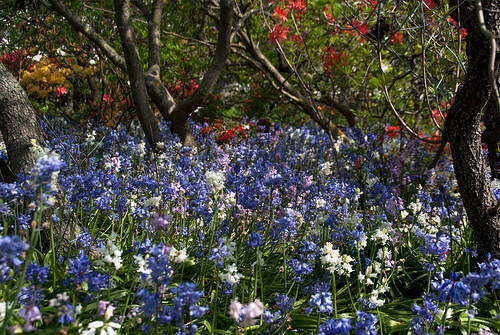

In [13]:


data_dir = data_dir / 'flower_photos'
image_count = len(list(data_dir.glob('*/*.jpg')))

print(data_dir)
print(list(data_dir.glob('*/*.jpg')))
print(image_count)

#roses = list(data_dir.glob('roses/*'))
#PIL.Image.open(str(roses[0]))
#PIL.Image.open(str(roses[1]))


tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[1]))

#PIL.Image.open(str(tulips[0]))


In [14]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


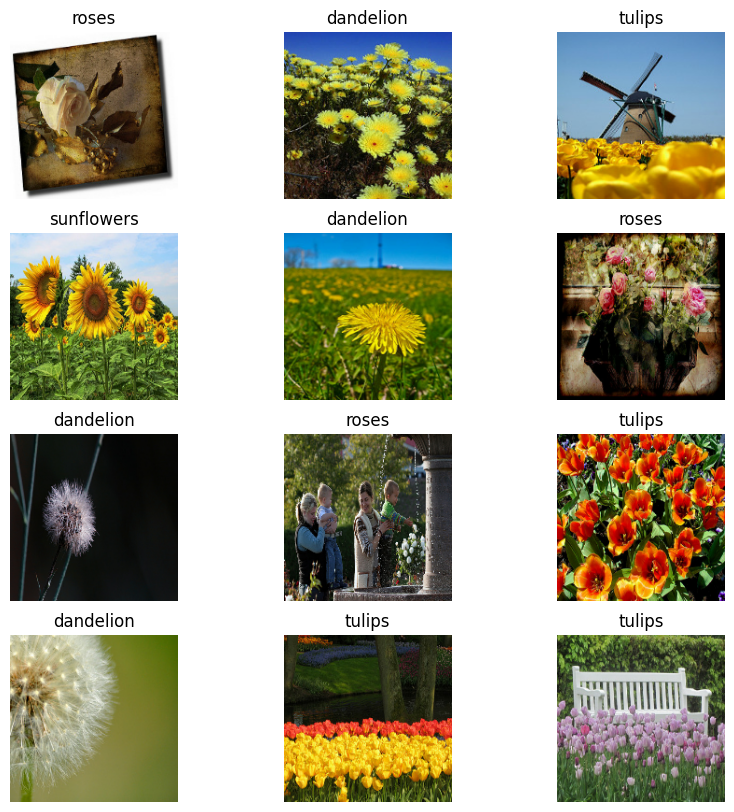

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
normalization_layer = layers.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [20]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

c:\Rohit\Python\python-3.11.4-embed-amd64\Python\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 228ms/step - accuracy: 0.3502 - loss: 1.6119 - val_accuracy: 0.5490 - val_loss: 1.1120
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 244ms/step - accuracy: 0.5903 - loss: 0.9929 - val_accuracy: 0.6117 - val_loss: 0.9656
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 255ms/step - accuracy: 0.6812 - loss: 0.8035 - val_accuracy: 0.6322 - val_loss: 0.9485
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 258ms/step - accuracy: 0.7511 - loss: 0.6823 - val_accuracy: 0.6730 - val_loss: 0.8673
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 286ms/step - accuracy: 0.8579 - loss: 0.4054 - val_accuracy: 0.6662 - val_loss: 0.9273
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 301ms/step - accuracy: 0.8852 - loss: 0.2959 - val_accuracy: 0.6785 - val_loss: 1.0509
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.9550 - loss: 0.1325 - val_accuracy: 0.6853 - val_loss: 1.1404
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - accuracy: 0.9766 - loss: 0.0809 - val_accu

In Order to Improve Accuracy need to stop model overfitting. Avoid Overfitting by either Data Augmentation or Dropout Methods


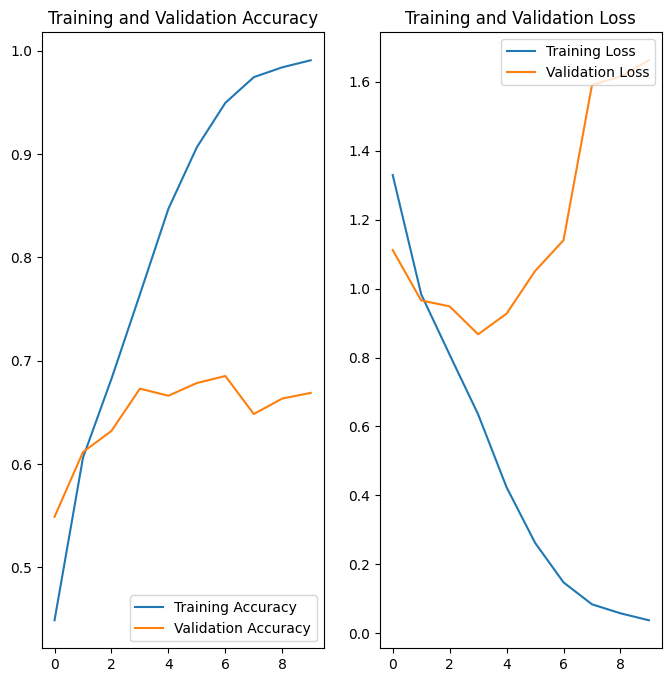

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
This image most likely belongs to sunflowers with a 100.00 percent confidence.


In [30]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('../models/model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\PC\AppData\Local\Temp\tmp07m9chvh\assets


INFO:tensorflow:Assets written to: C:\Users\PC\AppData\Local\Temp\tmp07m9chvh\assets


Saved artifact at 'C:\Users\PC\AppData\Local\Temp\tmp07m9chvh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2276981187472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276981186704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276981187664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276981186320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276981186128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276981187280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276981191504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276981181520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276981187088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276981180752: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [31]:
TF_MODEL_FILE_PATH = '../models/model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor'], 'outputs': ['output_0']}}

In [32]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)
print(np.max(np.abs(predictions - predictions_lite)))